In [1]:
from treecalculator import TreeCalculator
from treemodel import TreeModel
import pickle
import cv2
import numpy as np
from skimage.filters.rank import entropy, mean
from skimage.morphology import square
import math
import scipy.misc
import matplotlib.pyplot as plt
from keras.models import load_model
import sPickle
%matplotlib inline

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
nn_model = load_model('NNModelOne256LayerLess.h5')
images = pickle.load(open('images-lausanne-zoom-16.p', 'rb'))['sat']
# preprocessed_images = []
# for p in sPickle.s_load(open('PreprocessedDataLausanne16.p', 'r')):
#     preprocessed_images.append(p)
# print(len(preprocessed_images))

tree_model = TreeModel(nn_model)

tree_calculator = TreeCalculator(tree_model)

In [14]:
results = {
    'sat': [],
    'pred': []
}

for i, img in enumerate(images[:100]):
    pred = tree_model.predict_proba(images[i])
    results['sat'].append(img)
    results['pred'].append(pred)
    print('Processed image {}/{}'.format(i+1, len(images)))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Processed image 1/702
Processed image 2/702
Processed image 3/702
Processed image 4/702
Processed image 5/702
Processed image 6/702
Processed image 7/702
Processed image 8/702
Processed image 9/702
Processed image 10/702
Processed image 11/702
Processed image 12/702
Processed image 13/702
Processed image 14/702
Processed image 15/702
Processed image 16/702
Processed image 17/702
Processed image 18/702
Processed image 19/702
Processed image 20/702
Processed image 21/702
Processed image 22/702
Processed image 23/702
Processed image 24/702
Processed image 25/702
Processed image 26/702
Processed image 27/702
Processed image 28/702
Processed image 29/702
Processed image 30/702
Processed image 31/702
Processed image 32/702
Processed image 33/702
Processed image 34/702
Processed image 35/702
Processed image 36/702
Processed image 37/702
Processed image 38/702
Processed image 39/702
Processed image 40/702
Processed image 41/702
Processed image 42/702
Processed image 43/702
Processed image 44/7

In [19]:
pickle.dump(results, open('NonThresholdedPredictedDataLausanne16NN.p', 'wb'))

In [3]:
results = pickle.load(open('NonThresholdedPredictedDataLausanne16NN.p', 'rb'))

In [15]:
sparsities = []
coverages = []
for pred in results['pred']:
    binary_pred = tree_calculator.threshold_image(tree_calculator.filter_image(pred))
    coverages.append(np.count_nonzero(binary_pred) / binary_pred.size)
    ret, thresh_entropy = cv2.threshold(entropy(binary_pred, square(10)), 0.5, 1, cv2.THRESH_BINARY)
    entropy_zero_count = np.count_nonzero(thresh_entropy)
    normal_zero_count = np.count_nonzero(binary_pred)
    if normal_zero_count == 0:
        sparsity = 0
    elif entropy_zero_count == 0:
        sparsity = pred.size
    else:
        sparsity = np.count_nonzero(binary_pred) / entropy_zero_count if entropy_zero_count > 0 else pred.size
#     sparsity /= pred.size
    sparsities.append(sparsity)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [21]:
pickle.dump({'spars': sparsities, 'cov': coverages}, open('CoveragesAndSparsitiesDataLausanne16NN.p', 'wb'))

In [4]:
data = pickle.load(open('CoveragesAndSparsitiesDataLausanne16NN.p', 'rb'))
sparsities = data['spars']
coverages = data['cov']

In [16]:
sparsities = np.array(sparsities)
coverages = np.array(coverages)

arg_sorted_sparsities = np.argsort(sparsities)
arg_sorted_coverages = np.argsort(coverages)
    
reordered_sparsities = sparsities[arg_sorted_sparsities]
reordered_coverages = coverages[arg_sorted_sparsities]

In [17]:
dim = 10
block_size = int(len(sparsities) / dim)
sub_block_size = int(block_size / dim)
idx_matrix = np.empty((dim, dim), dtype=np.int32)
for i in range(dim):
    c_arg_sparsities = arg_sorted_sparsities[i*block_size:(i+1)*block_size]
    c_arg_coverages = []
    for arg_spars in c_arg_sparsities:
        c_arg_coverages.append(np.where(arg_sorted_coverages == arg_spars)[0][0])
    c_sorted_arg_coverages = np.argsort(c_arg_coverages)
    c_shrinked_sorted_arg_coverages = c_sorted_arg_coverages[::sub_block_size]
    for j in range(dim):
        idx = c_arg_sparsities[c_shrinked_sorted_arg_coverages[j]]
        idx_matrix[i,j] = idx

In [18]:
fig_size_a2 = (16.54, 23.39)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['sat'][idx_matrix[y,x]], cmap=plt.cm.Greens)
f.savefig('MidTerm/PosterNNLess/output1.pdf', dpi=300)
plt.close(f)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['pred'][idx_matrix[y,x]], cmap=plt.cm.Greens)
f.savefig('MidTerm/PosterNNLess/output2.pdf', dpi=300)
plt.close(f)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        binary_pred = tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx_matrix[y,x]]))
        axarr[y,x].imshow(binary_pred, cmap=plt.cm.Greens)
f.savefig('MidTerm/PosterNNLess/output3.pdf', dpi=300)
plt.close(f)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:16: RuntimeWarning: divide by zero encountered in log
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:16: RuntimeWarning: invalid value encountered in subtract
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:17: RuntimeWarning: divide by zero encountered in log
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:17: RuntimeWarning: invalid value encountered in subtract
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
C:\ProgramData\Anaconda

[[3.3623383e-08 4.1166697e-08 4.6171749e-08 ... 9.3682265e-01
  9.3128508e-01 9.1996509e-01]
 [3.7085751e-08 4.5444736e-08 5.3709421e-08 ... 9.0953535e-01
  9.1711581e-01 9.0341163e-01]
 [4.0647375e-08 5.6081987e-08 6.0745577e-08 ... 8.9375830e-01
  9.0829879e-01 9.0708709e-01]
 ...
 [9.0796357e-01 9.1076821e-01 9.0268785e-01 ... 9.0514749e-01
  9.1840756e-01 9.2403799e-01]
 [8.4985918e-01 8.7528270e-01 7.8767270e-01 ... 9.2575639e-01
  9.1926968e-01 9.1772372e-01]
 [6.9467765e-01 7.4061036e-01 7.4910033e-01 ... 9.3220562e-01
  9.1694742e-01 8.9387250e-01]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


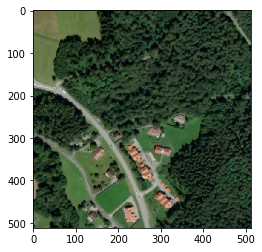

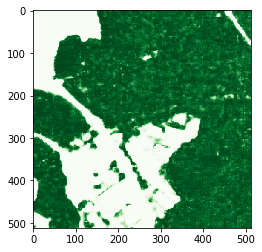

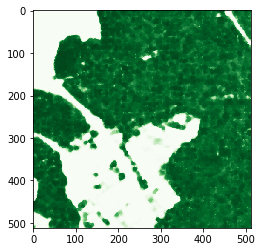

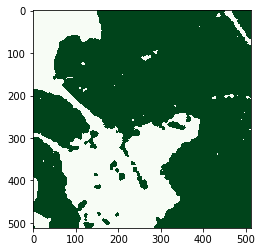

In [28]:
import matplotlib as mpl
import matplotlib.cm as cm

scal_map = cm.ScalarMappable(cmap=plt.cm.Greens)

img = results['sat'][idx_matrix[7,6]]
plt.figure()
plt.imshow(img)
scipy.misc.imsave('MidTerm/Examples/sat.png', img)
predict = tree_model.predict_proba(img)
plt.figure()
plt.imshow(predict, cmap=plt.cm.Greens)
scipy.misc.imsave('MidTerm/Examples/sat_predicted.png', scal_map.to_rgba(predict))
filtered = tree_calculator.filter_image(predict)
plt.figure()
plt.imshow(filtered, cmap=plt.cm.Greens)
scipy.misc.imsave('MidTerm/Examples/sat_predicted_filtered.png', scal_map.to_rgba(filtered))
# thresholded = tree_calculator.threshold_image(predict)
# plt.figure()
# plt.imshow(thresholded, cmap=plt.cm.Greens)
first_filter_then_threshold = tree_calculator.threshold_image(filtered)
plt.figure()
plt.imshow(first_filter_then_threshold, cmap=plt.cm.Greens)
scipy.misc.imsave('MidTerm/Examples/sat_predicted_filtered_thresholded.png', scal_map.to_rgba(first_filter_then_threshold))
# first_threshold_then_filter = tree_calculator.filter_image(thresholded)
# plt.figure()
# plt.imshow(first_threshold_then_filter, cmap=plt.cm.Greens)

# print(idx_matrix[2,7])
# print(idx_matrix[0,7])
# idx = idx_matrix[2,7]
# print(idx)
# print(sparsities[idx])
# print(coverages[idx])
# plt.imshow(results['sat'][idx])
# plt.figure()
# plt.imshow(results['pred'][idx])
# plt.figure()
# plt.imshow(tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx]), threshold=0.48))
# plt.figure()
# plt.imshow(tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx])))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


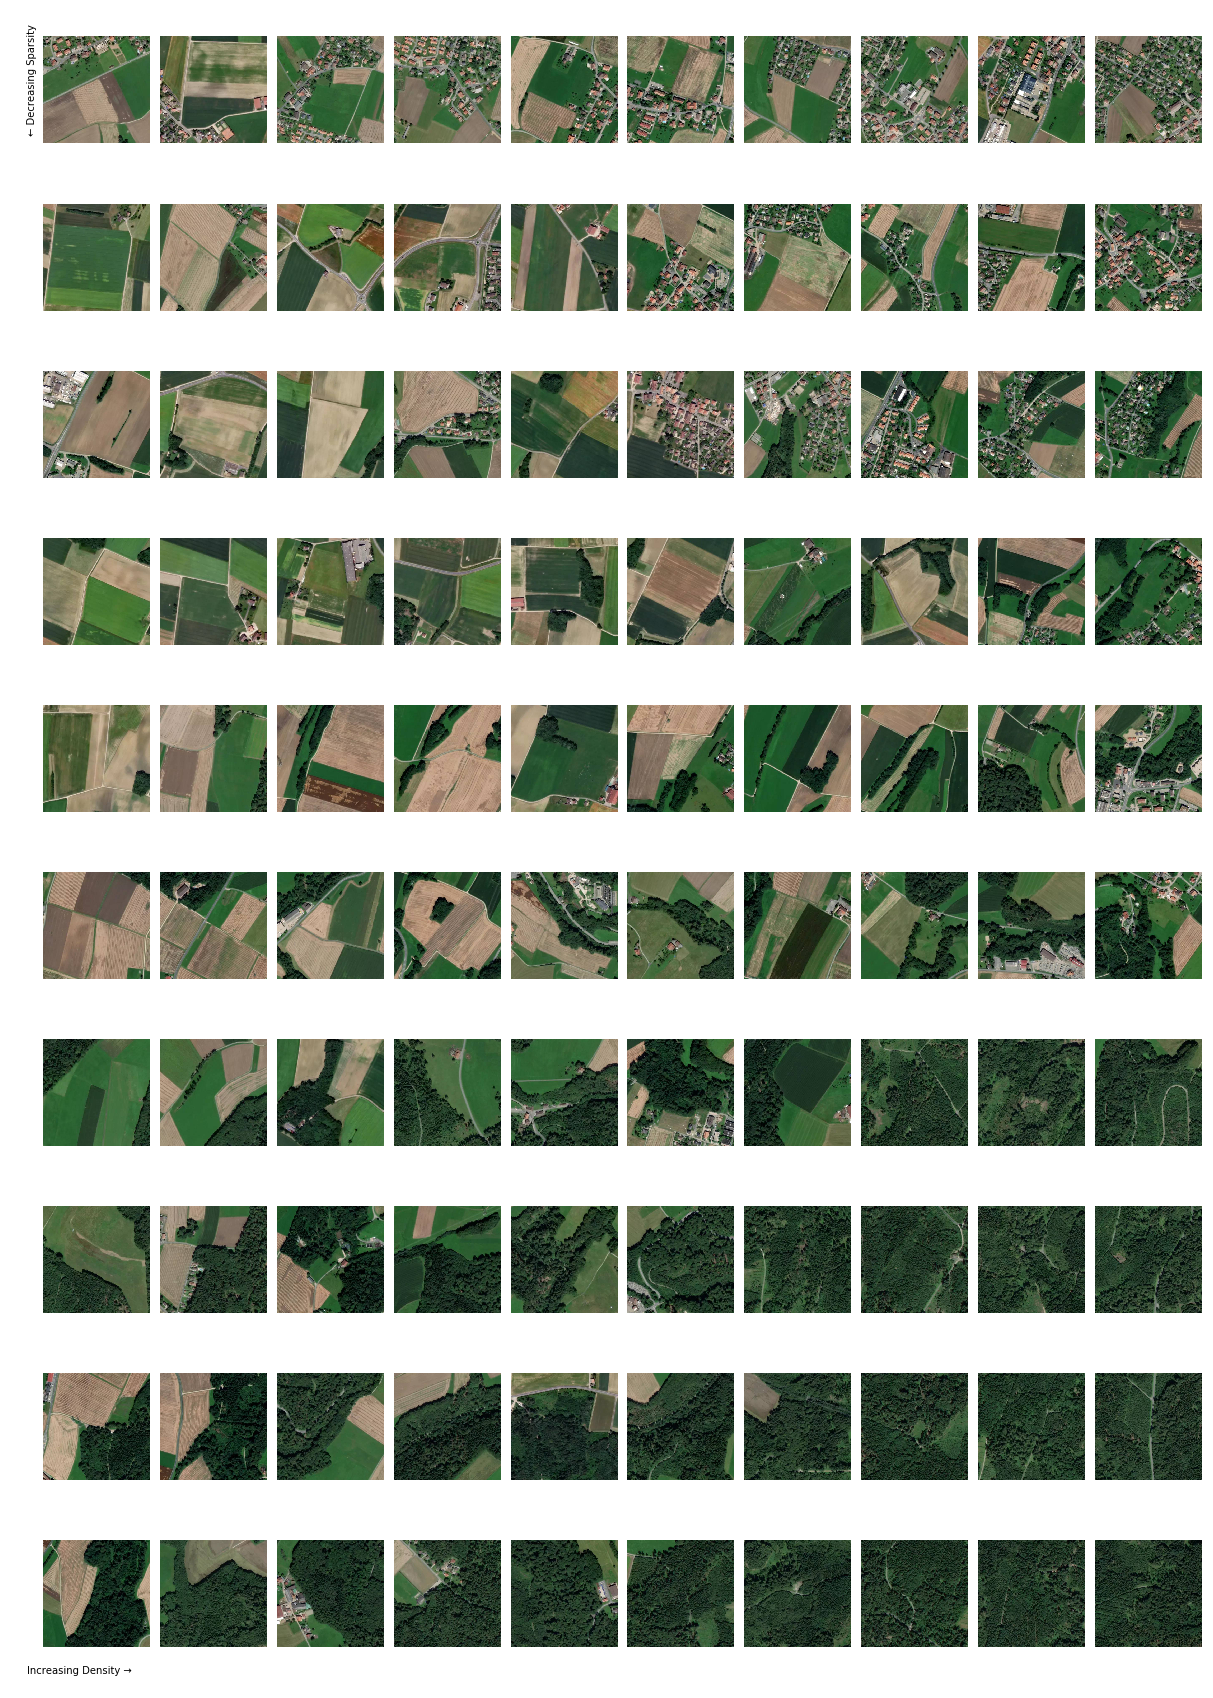

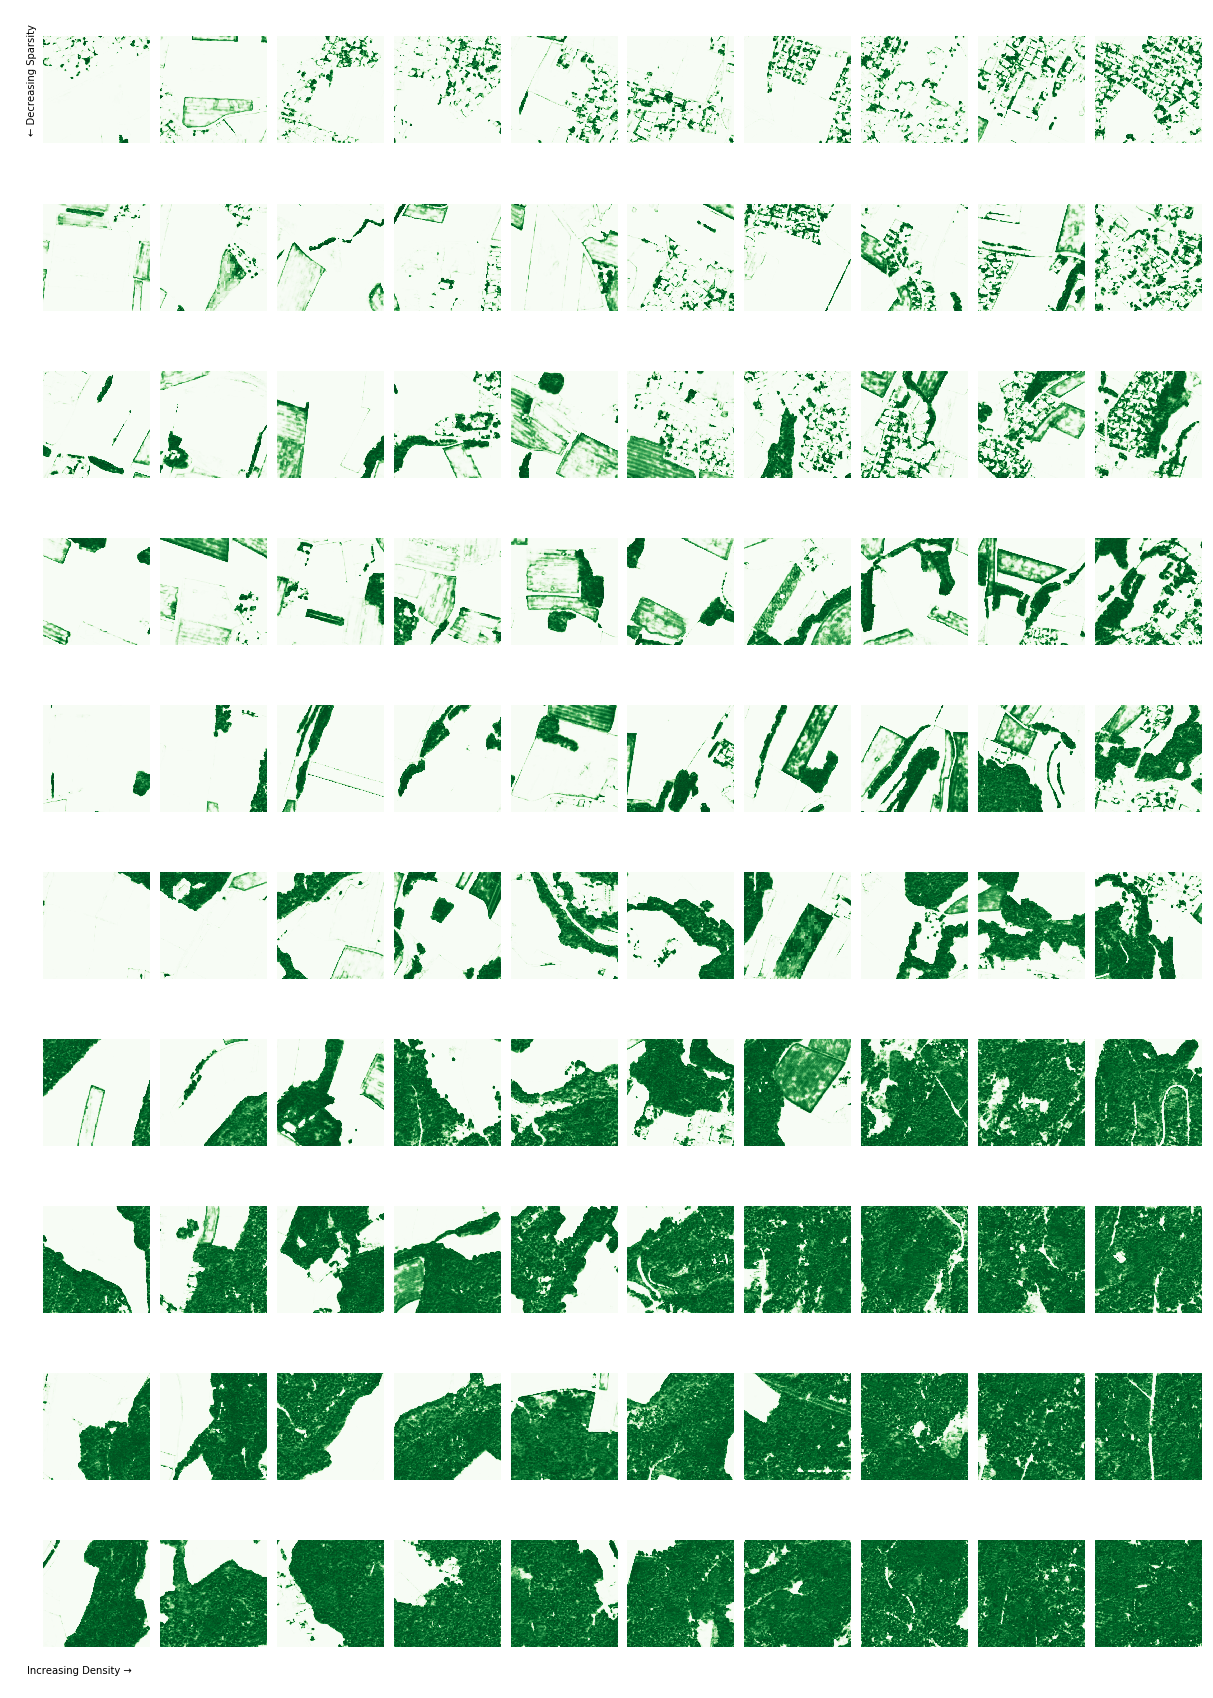

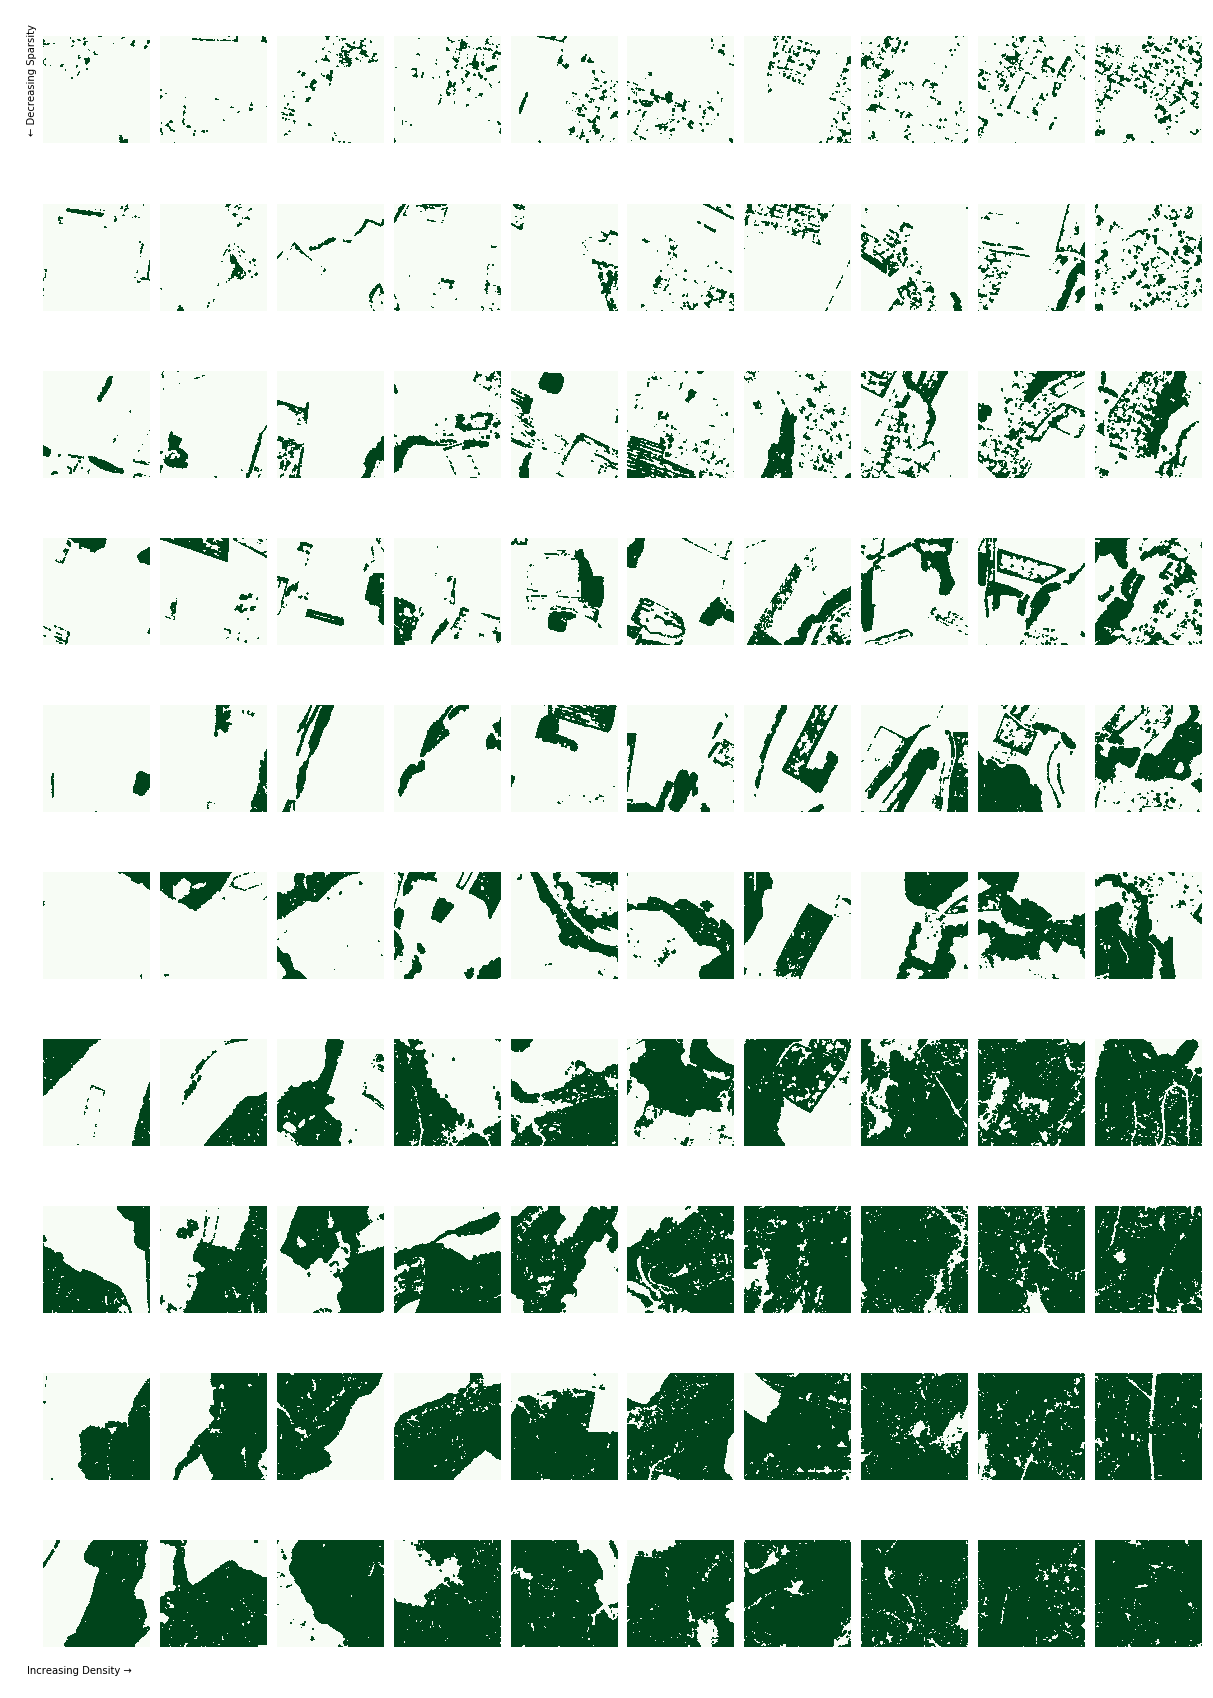

In [13]:
fig_size_a2 = (16.54, 23.39)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['sat'][idx_matrix[y,x]], cmap=plt.cm.Greens)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['pred'][idx_matrix[y,x]], cmap=plt.cm.Greens)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Incrhttp://localhost:8888/notebooks/Documents/EPFL/Personal%20Interaction%20Studio/Code/MidTermPresentationNN.ipynb#easing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        binary_pred = tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx_matrix[y,x]]))
        axarr[y,x].imshow(binary_pred, cmap=plt.cm.Greens)